<a href="https://colab.research.google.com/github/Mubarok982/Face-Rec/blob/main/Face_rec_WEBUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving archive (7).zip to archive (7) (2).zip
Found 122 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.9853 - loss: 0.2186 - val_accuracy: 1.0000 - val_loss: 0.0404
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 1.0000 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0157
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch

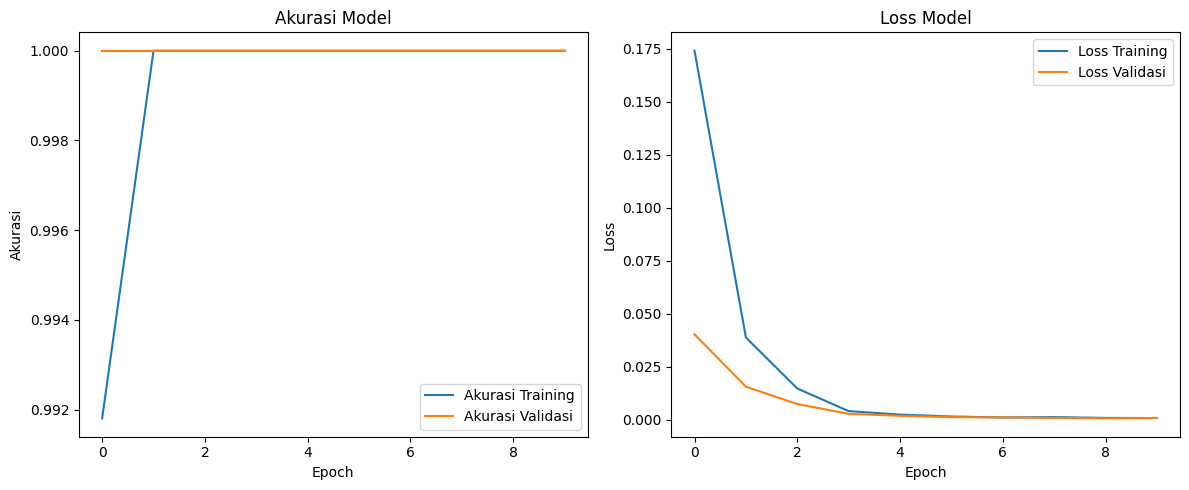

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt  # Tambahan untuk visualisasi
import os
from google.colab import files
import zipfile
import os

# Upload file ZIP dataset
uploaded = files.upload()

# Ekstrak file ZIP
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Cek apakah file berhasil diekstrak
os.listdir('/content/dataset')

# 1. Data Preprocessing
data_dir = '/content/dataset'

# Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load Data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Misalnya 0 untuk "kurang manusia", 1 untuk "lebih manusia"
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# 2. Membangun Model (Transfer Learning dengan MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layer MobileNetV2

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 3. Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 4. Training Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# 5. Evaluasi Model
loss, accuracy = model.evaluate(validation_generator)
print(f"Akurasi: {accuracy * 100:.2f}%")

# 6. Visualisasi Hasil Training
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Pilih mode input:
1. Kamera
2. Clipboard (Upload Gambar)
Masukkan pilihan (1/2): 2
Silakan upload gambar dari clipboard.


Saving poto_diri.jpg to poto_diri.jpg


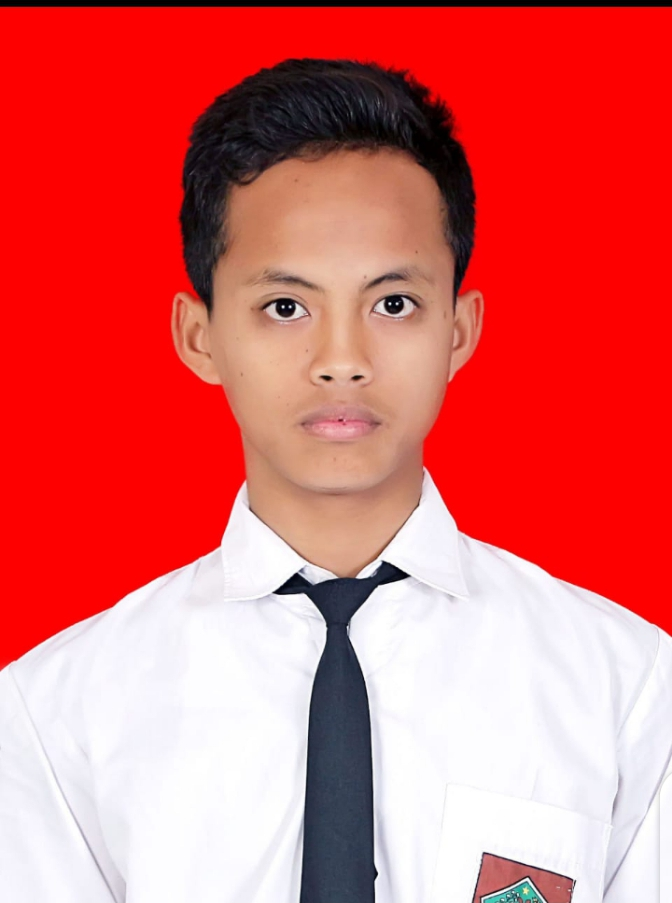

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Skor prediksi: 0.00
Prediksi: Kurang manusia


In [9]:
from google.colab import output
from IPython.display import display, Javascript
from PIL import Image
import cv2
import numpy as np
import base64
import io
from google.colab import files

# Fungsi untuk menangkap gambar dari kamera
def take_photo():
    js = Javascript('''
        async function takePhoto() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();
            await new Promise((resolve) => setTimeout(resolve, 1000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            document.body.removeChild(video);

            return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')

    display(js)
    data = output.eval_js("takePhoto()")  # Menunggu hasil dari JavaScript
    return data

# Fungsi untuk decode gambar hasil jepretan
def decode_image(data):
    header, encoded = data.split(",", 1)
    image_data = base64.b64decode(encoded)
    image = Image.open(io.BytesIO(image_data))
    return image

# Fungsi untuk menerima input gambar dari clipboard
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = Image.open(io.BytesIO(uploaded[filename]))
        return image
    return None

# Pilih mode input
print("Pilih mode input:")
print("1. Kamera")
print("2. Clipboard (Upload Gambar)")
choice = input("Masukkan pilihan (1/2): ")

if choice == "1":
    print("Mengaktifkan kamera...")
    data = take_photo()
    if data:
        image = decode_image(data)
    else:
        print("Gagal mengambil gambar.")
        image = None
elif choice == "2":
    print("Silakan upload gambar dari clipboard.")
    image = upload_image()
else:
    print("Pilihan tidak valid.")
    image = None

# Jika gambar berhasil didapatkan
if image:
    image.save("input_image.jpg")  # Simpan gambar untuk prediksi
    display(image)

    # Preprocessing gambar untuk model
    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi dengan model
    prediction = model.predict(img_array)
    print(f"Skor prediksi: {prediction[0][0]:.2f}")

    if prediction[0][0] >= 0.5:
        print("Prediksi: Lebih manusia")
    else:
        print("Prediksi: Kurang manusia")
else:
    print("Tidak ada gambar yang diproses.")
